The script follows Lesson-6 of the Fastai course on ML and Deep Learning. 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
from fastai.imports import *
np.set_printoptions(linewidth=130)

In [3]:
import os
from pathlib import Path
path = Path('/kaggle/input/titanic')

**Data preprocessing**

In [4]:
df = pd.read_csv(path/'train.csv')
tst_df = pd.read_csv(path/'test.csv')
modes = df.mode().iloc[0]

In [5]:
df

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [6]:
#The mode() function returns the most frequently occurring value(s) in each column of a DataFrame
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

With Random Forest, there isn't the need to create dummy variables like that was done for non-numeric columns in the linear models and NNs. Instead, those fields can be converted to categorical variables, which internally in Pandas makes a list of all the unique values in the column, and replaces each value with a number.


In [7]:
def proc_data(df):
    df['Fare'] = df.Fare.fillna(0)
    df.fillna(modes, inplace=True)
    df['LogFare'] = np.log1p(df['Fare'])
    df['Embarked'] = pd.Categorical(df.Embarked)
    df['Sex'] = pd.Categorical(df.Sex)

proc_data(df)
proc_data(tst_df)

In [8]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,B96 B98,S,2.110213
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C,4.280593
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,B96 B98,S,2.188856
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,3.990834
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,B96 B98,S,2.202765
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,B96 B98,S,2.639057
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,3.433987
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,24.0,1,2,W./C. 6607,23.4500,B96 B98,S,3.196630
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,3.433987


The categorical, continuous, and dependent variables are listed. It can be noticed here that Pclass is a continuous variable (not categorial like earlier models), because it's ordered (i.e, 1st, 2nd, and 3rd class have an order), and decision trees only care about order, not about absolute value.

In [9]:
cats=["Sex","Embarked"]
conts=['Age', 'SibSp', 'Parch', 'LogFare', 'Pclass']
dep="Survived"

In [10]:
df.Sex.head()

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: category
Categories (2, object): ['female', 'male']

In [11]:
#As noticed in the underline, the categorical variables are assigned unique values
df.Sex.cat.codes.head()

0    1
1    0
2    0
3    0
4    1
dtype: int8

**Random Forest** is based on a bunch of **Decision Trees**, which in turn uses **Binary Splits**

A binary split is where all rows are placed into one of two groups, based on whether they're above or below some threshold of some column. For example, we could split the rows of our dataset into males and females by using the threshold 0.5 and the column 'Sex' (since the values in the column are 0 for females and 1 for males).

A few good references are [1](https://www.youtube.com/watch?v=ZVR2Way4nwQ), [2](https://www.youtube.com/watch?v=v6VJ2RO66Ag)

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


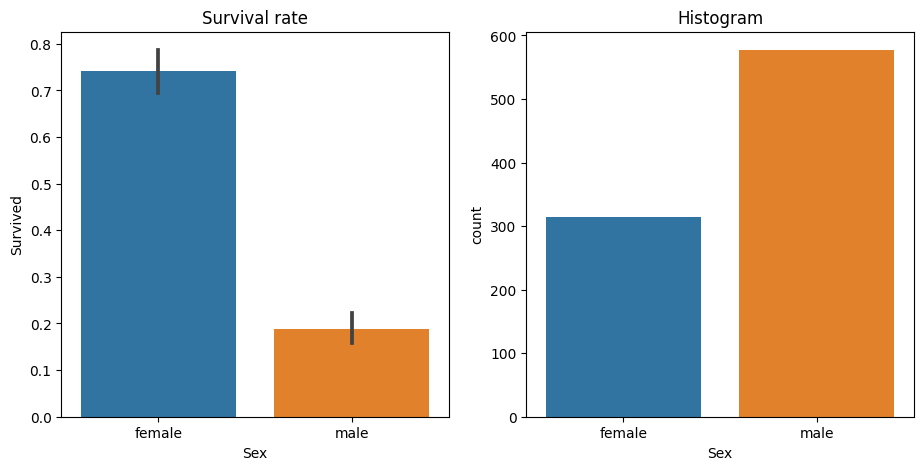

In [12]:
import seaborn as sns

fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.barplot(data=df, y=dep, x="Sex", ax=axs[0]).set(title="Survival rate")
sns.countplot(data=df, x="Sex", ax=axs[1]).set(title="Histogram");

##Females have a higher survival rate (probability) than males.

Creating a simple mode with the idea(assumption) that all females survived and no males did

In [13]:
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(42)
trn_df,val_df = train_test_split(df, test_size=0.25)
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

In [14]:
trn_df

#Notice column Sex and Embarked; now a value-based variable

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare
298,299,1,1,"Saalfeld, Mr. Adolphe",1,24.00,0,0,19988,30.5000,C106,2,3.449988
884,885,0,3,"Sutehall, Mr. Henry Jr",1,25.00,0,0,SOTON/OQ 392076,7.0500,B96 B98,2,2.085672
247,248,1,2,"Hamalainen, Mrs. William (Anna)",0,24.00,0,2,250649,14.5000,B96 B98,2,2.740840
478,479,0,3,"Karlsson, Mr. Nils August",1,22.00,0,0,350060,7.5208,B96 B98,2,2.142510
305,306,1,1,"Allison, Master. Hudson Trevor",1,0.92,1,2,113781,151.5500,C22 C26,2,5.027492
...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,107,1,3,"Salkjelsvik, Miss. Anna Kristine",0,21.00,0,0,343120,7.6500,B96 B98,2,2.157559
270,271,0,1,"Cairns, Mr. Alexander",1,24.00,0,0,113798,31.0000,B96 B98,2,3.465736
860,861,0,3,"Hansen, Mr. Claus Peter",1,41.00,2,0,350026,14.1083,B96 B98,2,2.715244
435,436,1,1,"Carter, Miss. Lucile Polk",0,14.00,1,2,113760,120.0000,B96 B98,2,4.795791


In [15]:
#creating the independent (x) and dependent (y) variables

def xs_y(df):
    xs = df[cats+conts].copy()
    return xs,df[dep] if dep in df else None

trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

In [16]:
trn_xs,trn_y, val_xs,val_y

(     Sex  Embarked    Age  SibSp  Parch   LogFare  Pclass
 298    1         2  24.00      0      0  3.449988       1
 884    1         2  25.00      0      0  2.085672       3
 247    0         2  24.00      0      2  2.740840       2
 478    1         2  22.00      0      0  2.142510       3
 305    1         2   0.92      1      2  5.027492       1
 ..   ...       ...    ...    ...    ...       ...     ...
 106    0         2  21.00      0      0  2.157559       3
 270    1         2  24.00      0      0  3.465736       1
 860    1         2  41.00      2      0  2.715244       3
 435    0         2  14.00      1      2  4.795791       1
 102    1         2  21.00      0      1  4.360388       1
 
 [668 rows x 7 columns],
 298    1
 884    0
 247    1
 478    0
 305    1
       ..
 106    1
 270    0
 860    0
 435    1
 102    0
 Name: Survived, Length: 668, dtype: int64,
      Sex  Embarked   Age  SibSp  Parch   LogFare  Pclass
 709    1         0  24.0      1      1  2.787834    

In [17]:
preds = val_xs.Sex==0

In [18]:
preds
#Check val_xs

709    False
439    False
840    False
720     True
39      True
       ...  
880     True
425    False
101    False
199     True
424    False
Name: Sex, Length: 223, dtype: bool

In [19]:
from sklearn.metrics import mean_absolute_error

#Basically checks the MAE between the surival(val_y) and preds(the corresponding female) 
mean_absolute_error(val_y, preds)

0.21524663677130046

The same can be attempted with a continuous variable, e.g., Fare

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


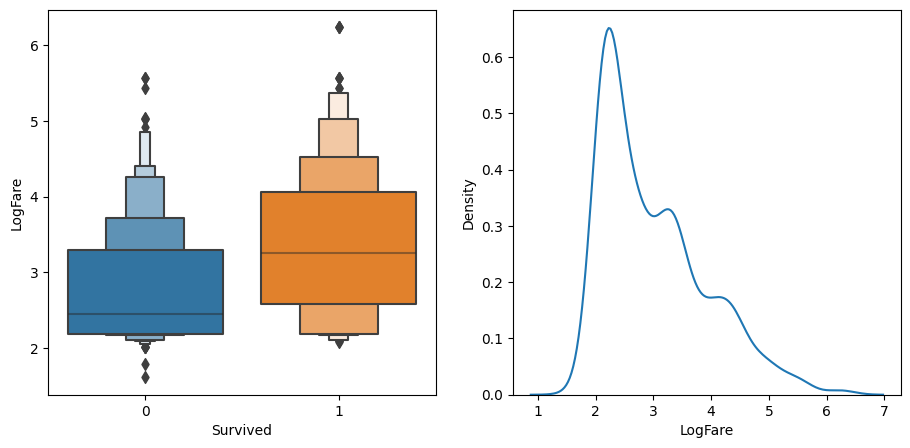

In [20]:
df_fare = trn_df[trn_df.LogFare>0]
fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.boxenplot(data=df_fare, x=dep, y="LogFare", ax=axs[0])
sns.kdeplot(data=df_fare, x="LogFare", ax=axs[1]);

The box plot shows quantiles of LogFare for each group of Survived==0 and Survived==1. It shows that the average LogFare for passengers that didn't survive is around 2.5, and for those that did is around 3.2. So it seems that people who paid more for their tickets were more likely to be selected for a lifeboat.

In [21]:
#Using LogFare 2.7 as the breaking point

preds = val_xs.LogFare>2.7
mean_absolute_error(val_y, preds)

0.336322869955157

This is quite a bit less accurate than the previous model with Sex as the single binary split.


It would be useful to try more columns and breakpoints more easily. It's possible to create a function that returns how good a model is, in order to try out a few different splits quickly, **a score function**. Instead of returning the mean absolute error, it calculates a a measure of impurity -- that is, how much the binary split creates two groups where the rows in a group are each similar to each other, or dissimilar. (say a group consisting of only females/males or mixed)

The similarity of rows inside a group can be measured by taking the standard deviation of the dependent variable. If it's higher, then it means the rows are more different from each other. This is then multiplied by the number of rows, since a bigger group has more impact than a smaller group.

In [22]:
def _side_score(side, y):
    tot = side.sum()
    if tot<=1: return 0
    return y[side].std()*tot

The helper function _side_score calculates a "score" for a subset of the data defined by a boolean mask (side). It is used to evaluate how well a split separates the target variable (y).

*side* is the boolean mask (e.g., True for rows on one side of a split, False otherwise) and *y* is the target variable 

'tot = side.sum()': Counts the number of True values in side (i.e., the number of rows on this side of the split).

'if tot <= 1: return 0': If there is only 0 or 1 row on this side, return a score of 0 (to avoid division by zero or meaningless calculations).

'return y[side].std() * tot': Otherwise, return the standard deviation of y for the rows selected by side, multiplied by the number of rows (tot).

The standard deviation measures the spread of y on this side of the split. A higher spread means the split is less effective at separating the target variable. Multiplying by the total weights (tot) the score by the size of the subset. This ensures that larger subsets contribute more to the total score.

----

Purpose:
This function calculates a total score for a split of the data based on a feature column (col) and a split value (split). It evaluates how well the split separates the target variable (y).

'col' is the feature column (e.g., a pandas Series) to split on, 'y' is the target variable, and 'split' is the breaking point value (e.g., rows with col <= split go to the left side, lhs, others to the right).

'lhs = col <= split': Creates a boolean mask for rows where col is less than or equal to split (to lhs).

'~lhs': The inverse of lhs (right-hand side of the split).

'_side_score(lhs, y)': Calculates the score for the LHS, _side_score(~lhs, y): Calculates the score for the RHS.

'return (_side_score(lhs, y) + _side_score(~lhs, y)) / len(y)': Returns the average score per row, normalized by the total number of rows.

The total score is the sum of the left and right side scores, divided by the total number of rows. This gives an average "impurity" or "spread" of the target variable after the split. A lower score indicates a better split, as it means the target variable is more homogeneous (less spread out) on both sides of the split (More dependence on a certain component of the variable)

In [23]:
def score(col, y, split):
    lhs = col<=split
    return (_side_score(lhs,y) + _side_score(~lhs,y))/len(y)

In [24]:
score(trn_xs["Sex"], trn_y, 0.5)

0.4078753098206398

In [25]:
score(trn_xs["LogFare"], trn_y, 2.7)

0.4718087395209973

**Sex** appears to be a better split. To make it easier to find the best binary split, a simple interactive tool can be created

In [26]:
#For continuous variable

def iscore(nm, split):
    col = trn_xs[nm]
    return score(col, trn_y, split)

from ipywidgets import interact
interact(nm=conts, split=15.5)(iscore);

interactive(children=(Dropdown(description='nm', options=('Age', 'SibSp', 'Parch', 'LogFare', 'Pclass'), value…

In [27]:
#For categorical variable

interact(nm=cats, split=2)(iscore);

interactive(children=(Dropdown(description='nm', options=('Sex', 'Embarked'), value='Sex'), IntSlider(value=2,…

That works well enough, but it's rather slow and fiddly. 

The best fit can be computed (determined) automatically. For example, for 'Age' first all possible split point are collected, followed by determining score() for each point and finding the lowest score

In [28]:
#finding all unique ages (split points)
nm = "Age"
col = trn_xs[nm]
unq = col.unique()
unq.sort()
unq

array([ 0.42,  0.67,  0.75,  0.83,  0.92,  1.  ,  2.  ,  3.  ,  4.  ,  5.  ,  6.  ,  7.  ,  8.  ,  9.  , 10.  , 11.  , 12.  ,
       13.  , 14.  , 14.5 , 15.  , 16.  , 17.  , 18.  , 19.  , 20.  , 21.  , 22.  , 23.  , 24.  , 24.5 , 25.  , 26.  , 27.  ,
       28.  , 28.5 , 29.  , 30.  , 31.  , 32.  , 32.5 , 33.  , 34.  , 34.5 , 35.  , 36.  , 36.5 , 37.  , 38.  , 39.  , 40.  ,
       40.5 , 41.  , 42.  , 43.  , 44.  , 45.  , 45.5 , 46.  , 47.  , 48.  , 49.  , 50.  , 51.  , 52.  , 53.  , 54.  , 55.  ,
       55.5 , 56.  , 57.  , 58.  , 59.  , 60.  , 61.  , 62.  , 64.  , 65.  , 70.  , 70.5 , 74.  , 80.  ])

In [29]:
#Calculating score for each unique value 

scores = np.array([score(col, trn_y, o) for o in unq if not np.isnan(o)])

In [30]:
scores

array([0.48447755, 0.48351588, 0.48158676, 0.48061929, 0.47964987, 0.480937  , 0.48347294, 0.48171397, 0.47987776, 0.47884826,
       0.47831672, 0.47949847, 0.47957573, 0.48092137, 0.48130659, 0.48200571, 0.48163287, 0.48124801, 0.48151498, 0.48183316,
       0.48105614, 0.48202484, 0.48178211, 0.48337829, 0.48439618, 0.48501782, 0.48545475, 0.48556795, 0.48550856, 0.48554074,
       0.48550094, 0.48504976, 0.48480161, 0.48561331, 0.4852559 , 0.48513473, 0.48529147, 0.48530156, 0.48543741, 0.48569729,
       0.48571309, 0.48571467, 0.4856701 , 0.48563657, 0.48579877, 0.48579767, 0.4858019 , 0.48580095, 0.48580002, 0.48580178,
       0.48580211, 0.48579777, 0.4857996 , 0.48580236, 0.48579236, 0.48580043, 0.48580303, 0.4858034 , 0.4857613 , 0.4855666 ,
       0.48579394, 0.48580506, 0.48580434, 0.48580707, 0.48579364, 0.48580788, 0.48581017, 0.48580597, 0.48581077, 0.48576815,
       0.48580167, 0.48545792, 0.48567909, 0.48542059, 0.48557468, 0.48492654, 0.4852198 , 0.48548666, 0.485902

In [31]:
# scores.argmin() returns the index of the smallest value or score, using it on the unq list finds the age. 
unq[scores.argmin()]

#6 is the best split point for Age

6.0

The function implements the whole idea

In [32]:
def min_col(df, nm):
    col,y = df[nm],df[dep]
    unq = col.dropna().unique()
    scores = np.array([score(col, y, o) for o in unq if not np.isnan(o)])
    idx = scores.argmin()
    return unq[idx],scores[idx]

min_col(trn_df, "Age")

(6.0, 0.47831671750899085)

In [33]:
#Finding the best splitting point and score for each of the categorical and continuous variables

cols = cats+conts
{o:min_col(trn_df, o) for o in cols}

{'Sex': (0, 0.4078753098206398),
 'Embarked': (0, 0.478833425731479),
 'Age': (6.0, 0.47831671750899085),
 'SibSp': (4, 0.4783740258817423),
 'Parch': (0, 0.4805296527841601),
 'LogFare': (2.4390808375825834, 0.4620823937736595),
 'Pclass': (2, 0.4604826188580666)}

The analysis reveals Sex<=0 is the best split to use. 

Such a classifier is known as the **OneR classifier** and makes for a great baseline to improve for more sophisticated models.

The OneR rule had an error of around 0.215 (found earlier), which should be kept in mind while trying out more sophisticated approaches.

# Creating a decision tree

The OneR classifier predicts survival based only on Sex. 

Next, for each of the two groups, female and male, one more binary split is created by finding the single best split for females and the single best split for males.

First, Sex is removed from the list of possible splits (since it has already been used it and there would be only one possible split for that binary column), and two groups are created

In [34]:
cols.remove("Sex")
ismale = trn_df.Sex==1
males,females = trn_df[ismale],trn_df[~ismale]

In [35]:
#males
females

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare
247,248,1,2,"Hamalainen, Mrs. William (Anna)",0,24.0,0,2,250649,14.5000,B96 B98,2,2.740840
316,317,1,2,"Kantor, Mrs. Sinai (Miriam Sternin)",0,24.0,1,0,244367,26.0000,B96 B98,2,3.295837
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,B96 B98,2,2.188856
742,743,1,1,"Ryerson, Miss. Susan Parker ""Suzette""",0,21.0,2,2,PC 17608,262.3750,B57 B59 B63 B66,0,5.573579
367,368,1,3,"Moussa, Mrs. (Mantoura Boulos)",0,24.0,0,0,2626,7.2292,B96 B98,0,2.107689
...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,331,1,3,"McCoy, Miss. Agnes",0,24.0,2,0,367226,23.2500,B96 B98,1,3.188417
700,701,1,1,"Astor, Mrs. John Jacob (Madeleine Talmadge Force)",0,18.0,1,0,PC 17757,227.5250,C62 C64,0,5.431646
71,72,0,3,"Goodwin, Miss. Lillian Amy",0,16.0,5,2,CA 2144,46.9000,B96 B98,2,3.869116
106,107,1,3,"Salkjelsvik, Miss. Anna Kristine",0,21.0,0,0,343120,7.6500,B96 B98,2,2.157559


In [36]:
{o:min_col(males, o) for o in cols}

{'Embarked': (0, 0.387558187041091),
 'Age': (6.0, 0.37398283710105873),
 'SibSp': (4, 0.38758642275862637),
 'Parch': (0, 0.3874704821461953),
 'LogFare': (2.803360380906535, 0.38048562317581447),
 'Pclass': (1, 0.3815544200436083)}

In [37]:
{o:min_col(females, o) for o in cols}

{'Embarked': (0, 0.4295252982857326),
 'Age': (50.0, 0.4225927658431646),
 'SibSp': (4, 0.42319212059713585),
 'Parch': (3, 0.4193314500446157),
 'LogFare': (4.256321678298823, 0.413505983329114),
 'Pclass': (2, 0.3335388911567602)}

The analysis shows that the best next binary split for males is Age<=6, and for females is Pclass<=2.

By adding these rules, a decision tree can be created, where the model will first check whether Sex is female or male, and depending on the result, it will then check either the above Age or Pclass rules, as appropriate. The process is repeated, creating new additional rules for each of the four groups we've now created.

DecisionTreeClassifier from sklearn does the same

In [38]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

#max_leaf_nodes=4: Limits the tree to a maximum of 4 leaf nodes

m = DecisionTreeClassifier(max_leaf_nodes=4)
m.fit(trn_xs, trn_y)

DecisionTreeClassifier(max_leaf_nodes=4)

In [39]:
import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

't': The trained decision tree model

'out_file=None': The DOT data is returned as a string instead of being written to a file

'feature_names=df.columns': Uses the column names of the DataFrame df as feature names in the tree

'filled=True': Nodes are colored to indicate the majority class

'rounded=True': Nodes are drawn with rounded corners

'special_characters=True': Allows special characters in the tree

'rotate=False': The tree is drawn top-to-bottom (not rotated)

'precision=precision': Controls the number of decimal places for numerical values

're.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s)': Modifies the DOT string to set the size and aspect ratio of the tree for better visualization

'graphviz.Source()': Creates a graphviz.Source object, which can be rendered as an image

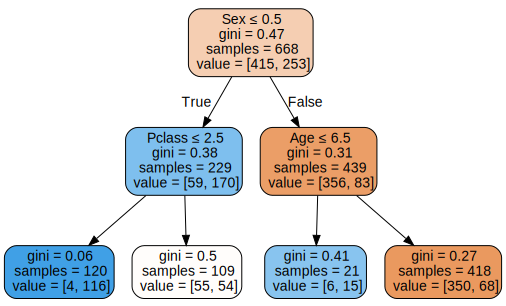

In [40]:
#'size' controls the size of the rendered graph (tree) visualization
draw_tree(m, trn_xs, size=10)

The splitting was as expected. Blue nodes show higher survival rates than the orange nodes. Each node shows how many rows ("samples") match that set of rules, and shows how many perish or survive ("values").

The survival rate is defined with **gini**, another measure of impurity, similar to the score() created earlier. **gini** calculates the probability that, if one picks two rows from a group, they'll get the same Survived result each time. If the group is all the same, the probability is 1.0, and 0.0 if they're all different. It can be defined as follows:

In [41]:
def gini(cond):
    act = df.loc[cond, dep]
    return 1 - act.mean()**2 - (1-act).mean()**2

gini(df.Sex=='female'), gini(df.Sex=='male')

(0.3828350034484158, 0.3064437162277842)

In [42]:
#Comparing to the earlier OneR version, which had an error of around 0.215 (found earlier)

mean_absolute_error(val_y, m.predict(val_xs))

0.2242152466367713

It's a tiny bit worse. Since this is such a small dataset (only has around 200 rows in our validation set) this small difference isn't really meaningful. Perhaps better results can be found when creating a bigger tree

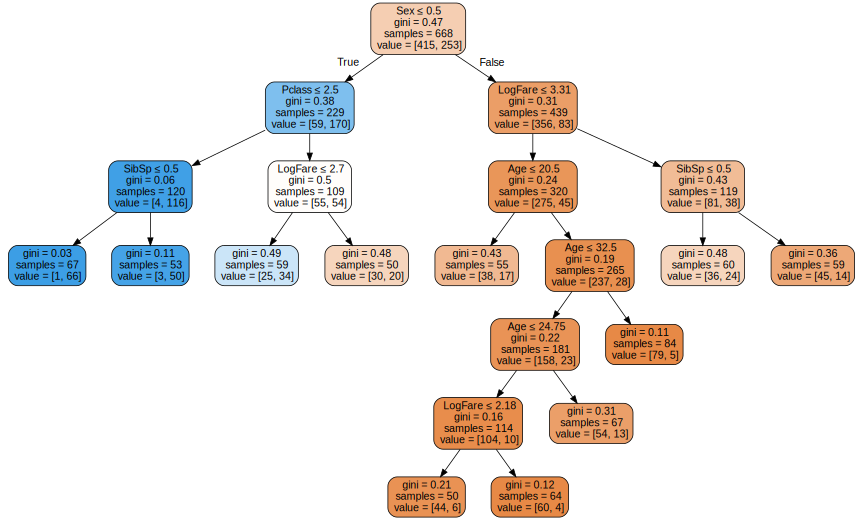

In [43]:
#Leaf nodes are created until each split has a sample size of 50 or more

m = DecisionTreeClassifier(min_samples_leaf=50)
m.fit(trn_xs, trn_y)
draw_tree(m, trn_xs, size=12)

In [44]:
mean_absolute_error(val_y, m.predict(val_xs))

0.18385650224215247

A small improvement, although the data set is very small to see the impact

# Random Forest

Leo Breiman came up with the idea of Random Forest, where one creates lots of bigger trees and takes the average of their predictions. This process is known as **bagging** (Bootstrapping + Aggregation). 

Bootstrapping involves creating a random subset of data for each decision tree, and the aggregation uses the averaged ensemble of each (uncorrelated) model's predictions. That way, the average prediction will be equal to the true target value, since the average of lots of uncorrelated random errors is zero.

In [45]:
def get_tree(prop=0.75):
    n = len(trn_y)
    idxs = random.choice(n, int(n*prop))
    return DecisionTreeClassifier(min_samples_leaf=5).fit(trn_xs.iloc[idxs], trn_y.iloc[idxs])

'n': The total number of samples in the original dataset.

'int(n*prop)': The number of samples to select for the subset (e.g., 75% of the original dataset if prop=0.75).

'replace=False': Default in NumPy's random.choice function. It ensures that each sample is selected without replacement, meaning no row is repeated in the subset.

In [46]:
trees = [get_tree() for t in range(100)]

In [47]:
all_probs = [t.predict(val_xs) for t in trees]
avg_probs = np.stack(all_probs).mean(0)

mean_absolute_error(val_y, avg_probs)

0.22726457399103142

The result is nearly identical to the earlier sklearn's RandomForestClassifier 

The main extra piece in a "real" random forest is that, as well as choosing a random sample of data for each tree, it also picks a random subset of columns for each split. 

In [48]:
#Using RandomForest in Sklearn

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(trn_xs, trn_y);
mean_absolute_error(val_y, rf.predict(val_xs))

0.18834080717488788

Random forests can also highlight which independent variables are the most important in the model, using 'feature_importances_'

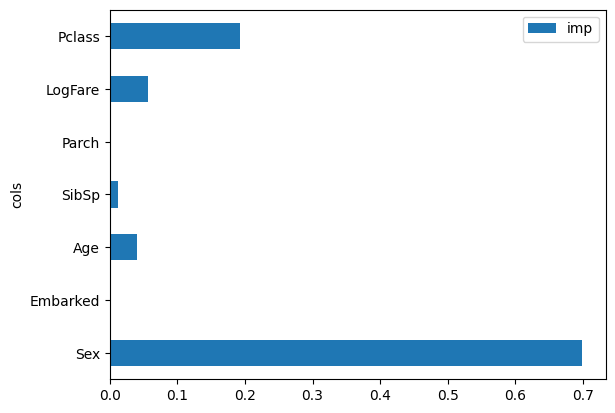

In [49]:
pd.DataFrame(dict(cols=trn_xs.columns, imp=m.feature_importances_)).plot('cols', 'imp', 'barh');

The most important feature is sex, followed by Pclass and LogFare

Random Forests average the feature importances across many trees, reducing the impact of noise or outliers in the data.

Because each tree in the Random Forest is trained on a different subset of the data, the feature importances reflect the overall usefulness of each feature across the entire dataset.

The rankings from a Random Forest are less likely to change dramatically if the model is retrained on slightly different data.

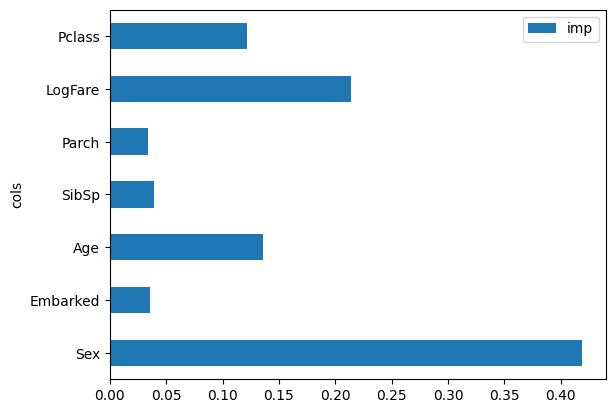

In [50]:
pd.DataFrame(dict(cols=trn_xs.columns, imp=rf.feature_importances_)).plot('cols', 'imp', 'barh');